# Analyse légère pic simple

In [54]:
from outils_analyse.identification_des_pics import determiner_indexes_maximums_scipy
from outils_analyse.lecture_des_fichiers import lire_csv_a_3_colonnes, crop_pour_conserver_que_la_partie_avec_rampe
from outils_analyse.conversion_temps_en_potentiel import \
    calculer_facteur_conversion_temps_en_potentiel_avec_mesure_rampe
import matplotlib.pyplot as plt
import os
import matplotlib
import numpy as np
# Grosseur du text dans les figures
matplotlib.rcParams.update({'font.size': 18})
out_dir = os.path.join("Graphiques", "anal_leger")
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

## Lire le fichier des résultats et transformer les valeurs en un array numpy
> Mettre les valeurs extraites à la place de `exemples_de_fichiers\exemple_de_donnees.csv`

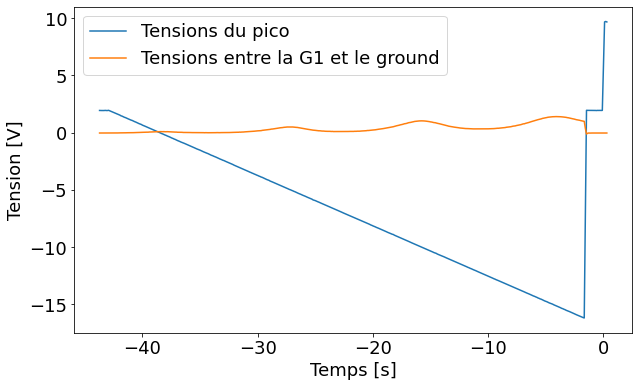

In [55]:
valeurs_en_array = lire_csv_a_3_colonnes("exemples_de_fichiers\exemple_de_donnees.csv", 9)

plt.figure(figsize=(10,6))
plt.plot(valeurs_en_array[:, 0], valeurs_en_array[:, 2], label="Tensions du pico")
plt.plot(valeurs_en_array[:, 0], valeurs_en_array[:, 1], label="Tensions entre la G1 et le ground")
plt.xlabel("Temps [s]")
plt.ylabel("Tension [V]")
plt.legend()
plt.show()

## Retirer les valeurs qui se trouvent à l'extérieur de l'activation du générateur de rampe

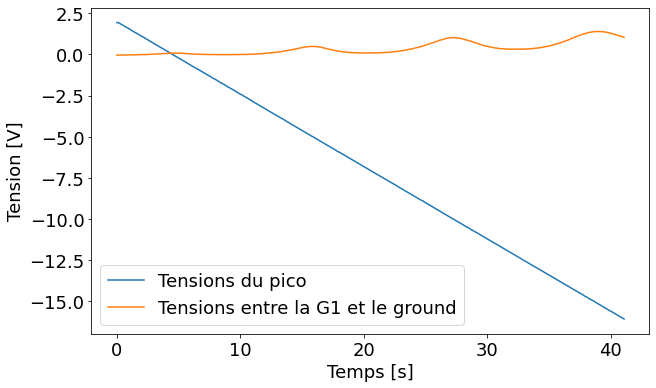

In [56]:
valeurs_cropped_debutant_par_t0 = crop_pour_conserver_que_la_partie_avec_rampe(valeurs_en_array, 2, 0.02, 0.1)

debut = min(valeurs_cropped_debutant_par_t0[:,0])
valeurs_cropped_debutant_par_t0[:,0]-=debut

plt.figure(figsize=(10,6))
plt.plot(valeurs_cropped_debutant_par_t0[:, 0], valeurs_cropped_debutant_par_t0[:, 2],
         label="Tensions du pico")
plt.plot(valeurs_cropped_debutant_par_t0[:, 0], valeurs_cropped_debutant_par_t0[:, 1],
         label="Tensions entre la G1 et le ground")
plt.xlabel("Temps [s]")
plt.ylabel("Tension [V]")
plt.legend()
plt.show()

facteur_conversion_temps_en_potentiel = calculer_facteur_conversion_temps_en_potentiel_avec_mesure_rampe(
    valeurs_cropped_debutant_par_t0, 0, 2)


## Pente de la tension du générateur de rampe + Tensions du pico en courant 

Pente = -0.43928176164627075 ± 0.034648001194000244 [V/s]


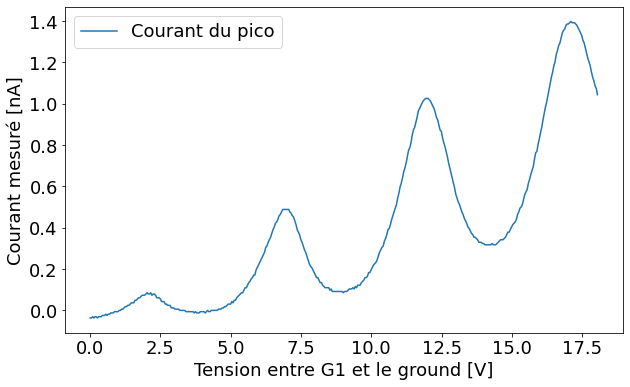

In [57]:
facteur_conversion_temps_en_potentiel = calculer_facteur_conversion_temps_en_potentiel_avec_mesure_rampe(
    valeurs_cropped_debutant_par_t0, 0, 2)
facteur_valeur = facteur_conversion_temps_en_potentiel[0]
facteur_incertitude = facteur_conversion_temps_en_potentiel[1]
print(f"Pente = {facteur_valeur} \u00B1 {facteur_incertitude} [V/s]")

valeurs_avec_bonnes_unites = valeurs_cropped_debutant_par_t0.copy()
valeurs_avec_bonnes_unites[:, 0] = -facteur_conversion_temps_en_potentiel[0] * valeurs_cropped_debutant_par_t0[:, 0] 

plt.figure(figsize=(10,6))
plt.plot(valeurs_avec_bonnes_unites[:, 0], valeurs_avec_bonnes_unites[:, 1],
        label="Courant du pico")
plt.xlabel("Tension entre G1 et le ground [V]")
plt.ylabel("Courant mesuré [nA]")
plt.legend()
plt.show()

## Déterminer l'emplacement approximatif des maximums
> Modifier `distance_minimum` au besoin

Estimation des pics: [ 2.0241425  6.933766  11.97259   17.09755  ] [V]


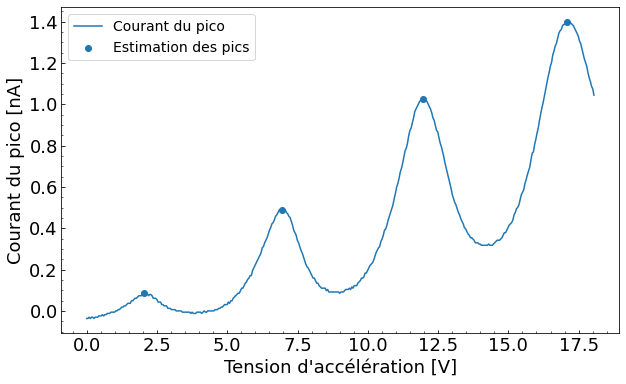

In [58]:
liste_des_indexes_des_pics = determiner_indexes_maximums_scipy(valeurs_avec_bonnes_unites, 1, distance_minumum=100)
print("Estimation des pics:", valeurs_avec_bonnes_unites[liste_des_indexes_des_pics, 0], "[V]")

valeurs_avec_bonnes_unites_determination_des_pics = valeurs_avec_bonnes_unites
liste_des_indexes_des_pics = liste_des_indexes_des_pics

plt.figure(figsize=(10,6))
plt.plot(valeurs_avec_bonnes_unites_determination_des_pics[:, 0],
        valeurs_avec_bonnes_unites_determination_des_pics[:, 1],
        label="Courant du pico")
plt.scatter(valeurs_avec_bonnes_unites_determination_des_pics[liste_des_indexes_des_pics, 0],
        valeurs_avec_bonnes_unites_determination_des_pics[liste_des_indexes_des_pics, 1],
        label="Estimation des pics")
plt.xlabel("Tension d'accélération [V]")
plt.ylabel("Courant du pico [nA]")
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='both', direction='in')
plt.minorticks_on()
plt.show()